# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("tracks.parquet")
catalogs = pd.read_parquet("catalog_names.parquet")
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
tracks.dtypes

track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [4]:
catalogs.dtypes

id       int64
type    object
name    object
dtype: object

In [5]:
interactions.dtypes

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [6]:
print(tracks.isnull().sum())
print(catalogs.isnull().sum())
print(interactions.isnull().sum())

track_id    0
albums      0
artists     0
genres      0
dtype: int64
id      0
type    0
name    0
dtype: int64
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


In [7]:
artists_ref = set(catalogs[catalogs['type'] == 'artist']['id'])
albums_ref = set(catalogs[catalogs['type'] == 'album']['id'])
genres_ref = set(catalogs[catalogs['type'] == 'genre']['id'])
tracks_ref = set(catalogs[catalogs['type'] == 'track']['id'])

all_artists = set(np.concatenate(tracks['artists'].values))
all_albums = set(np.concatenate(tracks['albums'].values))
all_genres = set(np.concatenate(tracks['genres'].values))

miss_artists = all_artists - artists_ref
miss_albums = all_albums - albums_ref
miss_genres = all_genres - genres_ref
miss_tracks = set(interactions['track_id'])-set(tracks['track_id'])
print(miss_artists)
print(miss_albums)
print(miss_genres)
print(miss_tracks)

set()
set()
{130, 131, 132, 133, 134, 135, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 124, 126}
set()


In [8]:
tracks_clean = tracks[
    tracks['artists'].apply(lambda x: all(i in artists_ref for i in x)) &
    tracks['albums'].apply(lambda x: all(i in albums_ref for i in x)) &
    tracks['genres'].apply(lambda x: all(i in genres_ref for i in x))
]

In [9]:
interactions_clean = interactions[interactions['track_id'].isin(tracks_clean['track_id'])]

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [10]:
print(f"Оригинальные треки: {len(tracks)}, Очищенные треки: {len(tracks_clean)}")
print(f"Оригинальные взаимодействия: {len(interactions)}, Очищенные взаимодействия: {len(interactions_clean)}")
print(f"Отсутствующие артисты: {len(miss_artists)}")
print(f"Отсутствующие альбомы: {len(miss_albums)}")
print(f"Отсутствующие жанры: {len(miss_genres)}")

Оригинальные треки: 1000000, Очищенные треки: 951655
Оригинальные взаимодействия: 222629898, Очищенные взаимодействия: 215165690
Отсутствующие артисты: 0
Отсутствующие альбомы: 0
Отсутствующие жанры: 30


Были удалены записи, чьи жанры отсутсвовали в таблице жанров

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

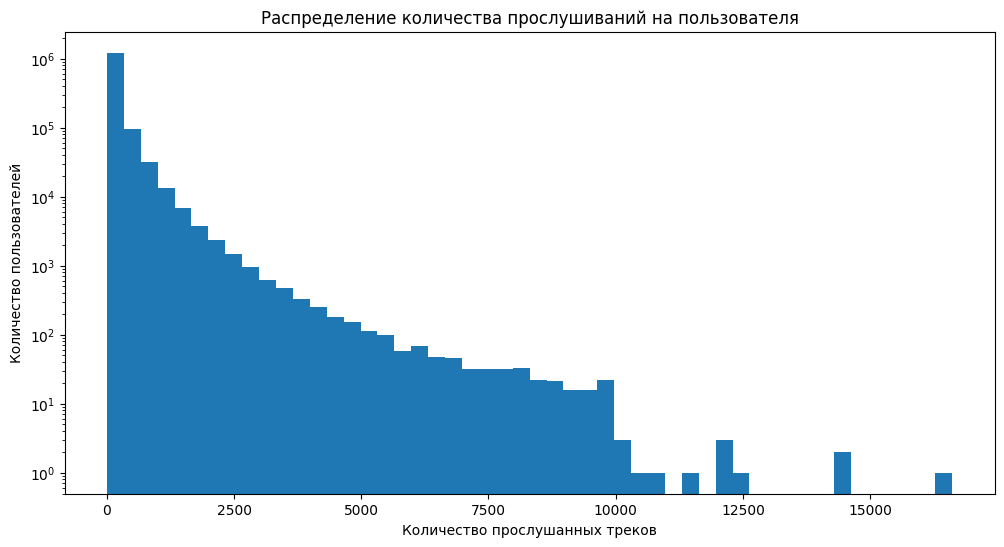

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


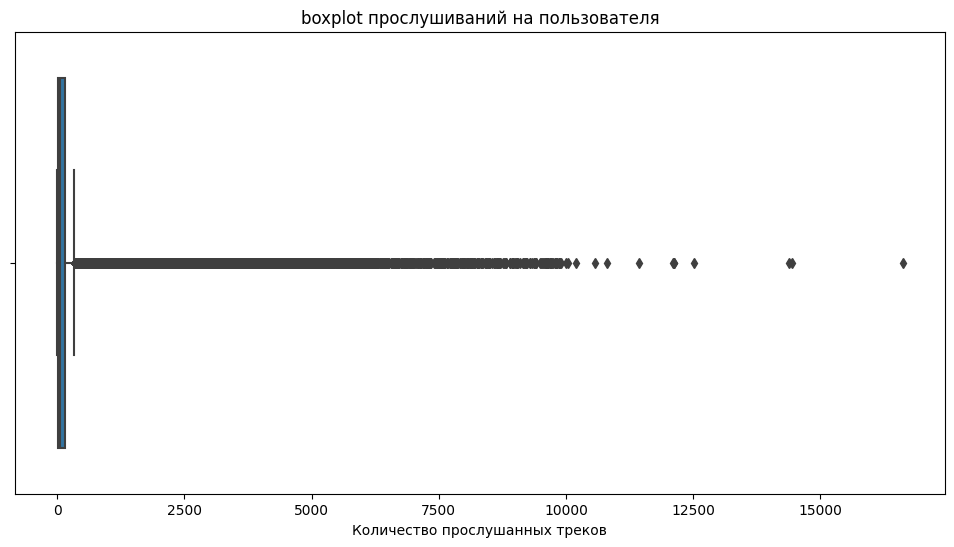

In [11]:
user_plays = interactions_clean.groupby('user_id').size().reset_index(name='play_count')

plt.figure(figsize=(12, 6))
plt.hist(user_plays['play_count'], bins=50, log=True)
plt.title('Распределение количества прослушиваний на пользователя')
plt.xlabel('Количество прослушанных треков')
plt.ylabel('Количество пользователей')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=user_plays['play_count'])
plt.title('boxplot прослушиваний на пользователя')
plt.xlabel('Количество прослушанных треков')
plt.show()

Наиболее популярные треки

In [12]:
track_names = catalogs[catalogs['type']=='track'].set_index('id')['name']
top_tracks = (
    interactions.groupby('track_id')
    .size()
    .reset_index(name='play_count')
    .sort_values('play_count', ascending=False)
    .head(10)
)

top_tracks['track_name'] = top_tracks['track_id'].map(track_names)

print("Топ-10 популярных треков:")
print(top_tracks[['track_name', 'play_count']])

Топ-10 популярных треков:
                     track_name  play_count
9098    Smells Like Teen Spirit      111062
483876                 Believer      106921
26665                      Numb      101924
512157               I Got Love       99490
829320                   Юность       86670
368072           Way Down We Go       86246
475289             Shape of You       85886
696106               In The End       85244
90461         Shape Of My Heart       85042
647237                     Life       84748


Наиболее популярные жанры

In [13]:
genre_names = catalogs[catalogs['type'] == 'genre'].set_index('id')['name']
# Создание связи трек-жанр (развертка списков жанров)
track_genres = tracks_clean[['track_id', 'genres']].explode('genres')

# Соединение с данными прослушиваний
genre_plays = (
    pd.merge(interactions[['track_id']], track_genres, on='track_id')
    .groupby('genres')
    .size()
    .reset_index(name='play_count')
    .sort_values('play_count', ascending=False)
    .head(10)
)

# Добавление названий жанров
genre_plays['genre_name'] = genre_plays['genres'].map(genre_names)

# Результат
print("Топ-10 популярных жанров:")
print(genre_plays[['genre_name', 'play_count']])

Топ-10 популярных жанров:
     genre_name  play_count
10          pop    55551141
70          rap    37799684
95      allrock    31085593
19       ruspop    26626241
2        rusrap    25303695
63  electronics    18376349
15        dance    16267222
1       rusrock    13166147
13         rock    12769718
40   foreignrap    12194520


Треки, которые никто не прослушал

In [14]:
listened_tracks = set(interactions_clean['track_id'])
unlistened_tracks = tracks_clean[~tracks_clean['track_id'].isin(listened_tracks)]
track_names = catalogs[catalogs['type'] == 'track'].set_index('id')['name']
unlistened_tracks['track_name'] = unlistened_tracks['track_id'].map(track_names)
print(unlistened_tracks)

Empty DataFrame
Columns: [track_id, albums, artists, genres, track_name]
Index: []


Все треки хотя бы раз были прослушаны!

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [1]:
track_names = catalogs[catalogs['type'] == 'track'].set_index('id')['name']
album_names = catalogs[catalogs['type'] == 'album'].set_index('id')['name']
artist_names = catalogs[catalogs['type'] == 'artist'].set_index('id')['name']
genre_names = catalogs[catalogs['type'] == 'genre'].set_index('id')['name']

tracks_clean['track_name'] = tracks_clean['track_id'].map(track_names)
tracks_clean['album_names'] = tracks_clean['albums'].apply(
    lambda x: [album_names.get(a, 'Unknown') for a in x]
)
tracks_clean['artist_names'] = tracks_clean['artists'].apply(
    lambda x: [artist_names.get(a, 'Unknown') for a in x]
)
tracks_clean['genre_names'] = tracks_clean['genres'].apply(
    lambda x: [genre_names.get(g, 'Unknown') for g in x]
)

# Формирование финальной таблицы
items_df = tracks_clean[[
    'track_id', 
    'track_name',
    'albums',
    'album_names',
    'artists',
    'artist_names',
    'genres',
    'genre_names'
]].rename(columns={
    'albums': 'album_ids',
    'artists': 'artist_ids',
    'genres': 'genre_ids'
})


NameError: name 'catalogs' is not defined

In [16]:
interactions_clean['started_at'] = pd.to_datetime(interactions_clean['started_at'])

interactions_clean['day_of_week'] = interactions_clean['started_at'].dt.dayofweek
interactions_clean['month'] = interactions_clean['started_at'].dt.month

/tmp/ipykernel_25266/3549876754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_clean['started_at'] = pd.to_datetime(interactions_clean['started_at'])
/tmp/ipykernel_25266/3549876754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_clean['day_of_week'] = interactions_clean['started_at'].dt.dayofweek
/tmp/ipykernel_25266/3549876754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [17]:
interactions_clean

,user_id,track_id,track_seq,started_at,day_of_week,month
0,0,99262,1,2022-07-17,6,7
1,0,589498,2,2022-07-19,1,7
2,0,590262,3,2022-07-21,3,7
3,0,590303,4,2022-07-22,4,7
4,0,590692,5,2022-07-22,4,7
...,...,...,...,...,...,...
287,1374582,95514767,288,2022-12-29,3,12
288,1374582,97220301,289,2022-12-29,3,12
289,1374582,97241171,290,2022-12-29,3,12
290,1374582,98542641,291,2022-12-29,3,12


# Сохранение данных

In [18]:
schema = pa.Schema.from_pandas(items_df)
with pq.ParquetWriter('items.parquet', schema=schema, compression='SNAPPY') as writer:
    table = pa.Table.from_pandas(items_df, schema=schema)
    writer.write_table(table)
print(f"Размер: {len(items_df)} записей")
print(f"Имена столбцов: {items_df.columns.tolist()}")

Размер: 951655 записей
Имена столбцов: ['track_id', 'track_name', 'album_ids', 'album_names', 'artist_ids', 'artist_names', 'genre_ids', 'genre_names']


In [19]:
schema = pa.Schema.from_pandas(interactions_clean)
with pq.ParquetWriter('events.parquet', schema=schema, compression='SNAPPY') as writer:
    table = pa.Table.from_pandas(interactions_clean, schema=schema)
    writer.write_table(table)
print(f"Размер: {len(interactions_clean)} записей")
print(f"Имена столбцов: {interactions_clean.columns.tolist()}")

Размер: 215165690 записей
Имена столбцов: ['user_id', 'track_id', 'track_seq', 'started_at', 'day_of_week', 'month']


Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
import s3fs
import pyarrow as pa
from dotenv import load_dotenv
import os

load_dotenv()

S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = s3fs.S3FileSystem(
        key=AWS_ACCESS_KEY_ID,
        secret=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
        client_kwargs={'region_name': 'ru-central1'}  # Регион по умолчанию
)

s3_events_path = 'recsys/data/events.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(items_df)
        
pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")


s3_events_path = 'recsys/data/events.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(interactions_clean)
        
pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")

Файл успешно сохранен: s3://s3-student-mle-20250228-7a89d0ddfb/recsys/data/items.parquet
Файл успешно сохранен: s3://s3-student-mle-20250228-7a89d0ddfb/recsys/data/events.parquet


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Необходимо перезапустить ядро и выполнить первую ячейку с импортами

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
import pandas as pd
import numpy as np
import math


In [2]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [3]:
items.head()

,track_id,track_name,album_ids,album_names,artist_ids,artist_names,genre_ids,genre_names
0,26,Complimentary Me,"[3, 2490753]","[Taller Children, Taller Children]",[16],[Elizabeth & the Catapult],"[11, 21]","[pop, folk]"
1,38,Momma's Boy,"[3, 2490753]","[Taller Children, Taller Children]",[16],[Elizabeth & the Catapult],"[11, 21]","[pop, folk]"
2,135,Atticus,"[12, 214, 2490809]","[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[84],[Noisettes],[11],[pop]
3,136,24 Hours,"[12, 214, 2490809]","[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[84],[Noisettes],[11],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),"[12, 214, 322, 72275, 72292, 91199, 213505, 24...","[Wild Young Hearts, Wild Young Hearts, Don't U...",[84],[Noisettes],[11],[pop]


In [4]:
events.head()

,user_id,track_id,track_seq,started_at,day_of_week,month
0,0,99262,1,2022-07-17,6,7
1,0,589498,2,2022-07-19,1,7
2,0,590262,3,2022-07-21,3,7
3,0,590303,4,2022-07-22,4,7
4,0,590692,5,2022-07-22,4,7


Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
train_events = events[events['started_at'] < '2022-12-16']
test_events = events[events['started_at'] >= '2022-12-16']

users_train = set(train_events['user_id'].unique())
users_test = set(test_events['user_id'].unique())
cold_users = users_test - users_train

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [7]:
top_tracks = train_events['track_id'].value_counts().head(100).index.tolist()
cold_test_events = test_events[test_events['user_id'].isin(cold_users)]

# 2. Recall@10 и Precision@10 для холодных пользователей
if not cold_test_events.empty:
    # Группировка по пользователям
    cold_user_groups = cold_test_events.groupby('user_id')['track_id'].apply(set).reset_index()
    cold_user_groups.columns = ['user_id', 'actual_items']
    
    # Добавление рекомендаций
    cold_user_groups['recommended'] = [set(top_tracks)] * len(cold_user_groups)
    
    # Расчет попаданий
    cold_user_groups['hits'] = cold_user_groups.apply(
        lambda row: row['actual_items'] & row['recommended'], axis=1
    )
    cold_user_groups['hit_count'] = cold_user_groups['hits'].apply(len)
    
    # Расчет метрик
    cold_user_groups['recall'] = cold_user_groups.apply(
        lambda row: row['hit_count'] / len(row['actual_items']) if len(row['actual_items']) > 0 else 0, 
        axis=1
    )
    cold_user_groups['precision'] = cold_user_groups['hit_count'] / len(top_tracks)
    
    # Усреднение
    recall_avg = cold_user_groups['recall'].mean()
    precision_avg = cold_user_groups['precision'].mean()
else:
    recall_avg = 0.0
    precision_avg = 0.0

# 3. Coverage (покрытие) - глобальная метрика
total_tracks = items['track_id'].nunique()
coverage = len(set(top_tracks)) / total_tracks

# 4. Novelty (новизна) - глобальная метрика
train_track_counts = train_events['track_id'].value_counts()
total_plays = train_track_counts.sum()

novelty_scores = []
for track_id in top_tracks:
    play_count = train_track_counts.get(track_id, 1)
    p = play_count / total_plays
    novelty_scores.append(-math.log2(p))

novelty = np.mean(novelty_scores)

print("Метрики для холодных пользователей:")
print(f"Recall@100: {recall_avg:.4f}")
print(f"Precision@100: {precision_avg:.4f}")
print(f"Coverage: {coverage:.6f}")
print(f"Novelty: {novelty:.4f}")

Метрики для холодных пользователей:
Recall@100: 0.0610
Precision@100: 0.0198
Coverage: 0.000105
Novelty: 11.7158


In [ ]:
import s3fs
import pyarrow as pa
from dotenv import load_dotenv
import os

load_dotenv()

S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = s3fs.S3FileSystem(
        key=AWS_ACCESS_KEY_ID,
        secret=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
        client_kwargs={'region_name': 'ru-central1'}  # Регион по умолчанию
)

s3_path = 'recsys/recommendations/top_popular.parquet'

full_path = f's3://{S3_BUCKET}/{s3_path}'
table = pa.Table.from_pandas(items_df)
        
pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")

# Персональные

Рассчитаем персональные рекомендации.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
# from implicit.evaluation import precision_at_k, recall_at_k
from collections import defaultdict

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datetime import datetime

SAMPLE_SIZE = 1000000

events = pd.read_parquet('events.parquet')
items = pd.read_parquet('items.parquet')

events = events.sample(min(SAMPLE_SIZE, len(events)), random_state=42)
items = items[items['track_id'].isin(events['track_id'])]

events['started_at'] = pd.to_datetime(events['started_at'])

# Определяем граничную дату
split_date = datetime(2022, 12, 16)

# Разбиваем данные
train_events = events[events['started_at'] < split_date]
test_events = events[events['started_at'] >= split_date]
# Создание словарей для идентификаторов

In [3]:
print(f"Тренировочная выборка: {len(train_events)} записей")
print(f"Тестовая выборка: {len(test_events)} записей")
print(f"Общее количество: {len(events)} записей")

# Проверяем что нет пересечений по датам
assert train_events['started_at'].max() < test_events['started_at'].min(), "Есть пересечение дат!"

Тренировочная выборка: 936981 записей
Тестовая выборка: 63019 записей
Общее количество: 1000000 записей


In [4]:
test_users = set(test_events['user_id'].unique())
train_users = set(train_events['user_id'].unique())
missing_users = test_users - train_users

if missing_users:
    print(f"Предупреждение: {len(missing_users)} пользователей есть в тесте, но нет в трейне")
    # Можно либо удалить этих пользователей из теста, либо добавить их в трейн
    test_events = test_events[~test_events['user_id'].isin(missing_users)]

# Аналогично для треков
test_tracks = set(test_events['track_id'].unique())
train_tracks = set(train_events['track_id'].unique())
missing_tracks = test_tracks - train_tracks

if missing_tracks:
    print(f"Предупреждение: {len(missing_tracks)} треков есть в тесте, но нет в трейне")
    test_events = test_events[~test_events['track_id'].isin(missing_tracks)]

Предупреждение: 26820 пользователей есть в тесте, но нет в трейне
Предупреждение: 5749 треков есть в тесте, но нет в трейне


In [5]:
print(f"Тренировочная выборка: {len(train_events)} записей")
print(f"Тестовая выборка: {len(test_events)} записей")
print(f"Общее количество: {len(events)} записей")


Тренировочная выборка: 936981 записей
Тестовая выборка: 27222 записей
Общее количество: 1000000 записей


In [6]:
valid_tracks = set(train_events['track_id'].unique())
items = items[items['track_id'].isin(valid_tracks)]

# Теперь можно создавать матрицы взаимодействий
def prepare_matrix(events_df):
    # Создаем маппинги только на основе трейна
    user_ids = sorted(train_events['user_id'].unique())
    track_ids = sorted(train_events['track_id'].unique())
    
    user_id_map = {id: idx for idx, id in enumerate(user_ids)}
    track_id_map = {id: idx for idx, id in enumerate(track_ids)}
    
    # Фильтруем события чтобы оставить только известных пользователей и треки
    events_df = events_df[
        events_df['user_id'].isin(user_id_map) & 
        events_df['track_id'].isin(track_id_map)
    ]
    
    rows = events_df['user_id'].map(user_id_map)
    cols = events_df['track_id'].map(track_id_map)
    data = np.ones(len(events_df))
    
    return coo_matrix(
        (data, (rows, cols)),
        shape=(len(user_ids), len(track_ids))
    ).tocsr()

train_matrix = prepare_matrix(train_events)
test_matrix = prepare_matrix(test_events)
del(events)
del(items)
# del(train_events)
del(test_events)

In [9]:
model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.01, random_state=42)

model.fit(train_matrix)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:14<00:00,  1.50s/it]


In [13]:
train_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 936981 stored elements and shape (428666, 203210)>

In [14]:
from tqdm import tqdm

user_ids = sorted(train_events['user_id'].unique())
track_ids = sorted(train_events['track_id'].unique())

user_id_map = {id: idx for idx, id in enumerate(user_ids)}
track_id_map = {id: idx for idx, id in enumerate(track_ids)}
reverse_track_map = {idx: id for id, idx in track_id_map.items()}

# del(train_events)

K=10

def evaluate_model(model, train_matrix, test_matrix, k=50):
    precisions = []
    recalls = []
    recommended_items = set()
    item_popularity = defaultdict(int)
    
    # Считаем популярность треков в трейне
    train_counts = np.array(train_matrix.sum(axis=0)).flatten()
    
    for user_idx in tqdm(range(train_matrix.shape[0]), desc="Оценка"):
        # Пропускаем пользователей без тестовых данных
        if test_matrix[user_idx].sum() == 0:
            continue
            
        # Получаем рекомендации
        recs, _ = model.recommend(user_idx, train_matrix[user_idx], N=k)
        recommended = [reverse_track_map[i] for i in recs if i in reverse_track_map]
        
        # Получаем тестовые треки
        _, test_cols = test_matrix[user_idx].nonzero()
        test_items = {reverse_track_map[i] for i in test_cols if i in reverse_track_map}
        
        # Расчет Precision и Recall
        relevant = set(recommended) & test_items
        precisions.append(len(relevant) / k)
        recalls.append(len(relevant) / len(test_items) if test_items else 0)
        
        # Для Coverage и Novelty
        for track in recommended:
            recommended_items.add(track)
            item_popularity[track] += 1
    
    # Coverage
    coverage = len(recommended_items) / len(track_ids)
    
    # Novelty (средняя энтропия популярности)
    popularities = [train_counts[track_id_map[track]] for track in recommended_items]
    novelty = -np.mean(np.log2(np.array(popularities) / train_counts.sum() + 1e-12))
    
    return {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'coverage': coverage,
        'novelty': novelty,
        'num_users': len(precisions)
    }

# Оценка модели
print("\nОценка модели...")
metrics = evaluate_model(model, train_matrix, test_matrix)

print("\nРезультаты:")
print(f"Precision@{K}: {metrics['precision']:.4f}")
print(f"Recall@{K}: {metrics['recall']:.4f}")
print(f"Coverage: {metrics['coverage']:.4f}")
print(f"Novelty: {metrics['novelty']:.4f}")
print(f"Оценено на {metrics['num_users']} пользователях")


Оценка модели...


Оценка: 100%|██████████| 428666/428666 [03:35<00:00, 1988.41it/s]


Результаты:
Precision@10: 0.0001
Recall@10: 0.0060
Coverage: 0.0056
Novelty: 13.3535
Оценено на 23871 пользователях


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

valid_tracks = items['track_id'].unique()
events = events[events['track_id'].isin(valid_tracks)]

# Создание маппингов
user_to_idx = {user_id: idx for idx, user_id in enumerate(events['user_id'].unique())}
track_to_idx = {track_id: idx for idx, track_id in enumerate(events['track_id'].unique())}
idx_to_track = {idx: track_id for track_id, idx in track_to_idx.items()}

In [3]:
def prepare_matrix(events_df):
    # Создаем маппинги только на основе трейна
    user_ids = sorted(events_df['user_id'].unique())
    track_ids = sorted(events_df['track_id'].unique())
    
    user_id_map = {id: idx for idx, id in enumerate(user_ids)}
    track_id_map = {id: idx for idx, id in enumerate(track_ids)}
    
    # Фильтруем события чтобы оставить только известных пользователей и треки
    events_df = events_df[
        events_df['user_id'].isin(user_id_map) & 
        events_df['track_id'].isin(track_id_map)
    ]
    
    rows = events_df['user_id'].map(user_id_map)
    cols = events_df['track_id'].map(track_id_map)
    data = np.ones(len(events_df))
    
    return coo_matrix(
        (data, (rows, cols)),
        shape=(len(user_ids), len(track_ids))
    ).tocsr()

In [4]:
user_indices = events['user_id'].map(user_to_idx)
track_indices = events['track_id'].map(track_to_idx)
interactions = prepare_matrix(events)

In [6]:
model = AlternatingLeastSquares(factors=50, iterations=10, regularization=0.01, random_state=42)

model.fit(interactions * 20)

100%|██████████| 10/10 [09:22<00:00, 56.23s/it]


In [8]:
from implicit.nearest_neighbours import CosineRecommender
recommender = CosineRecommender()
recommender.fit(model.item_factors)

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 2.389350652694702 seconds
  warnings.warn(
100%|██████████| 50/50 [00:02<00:00, 24.42it/s]


In [9]:
similar_tracks = []
for idx in range(len(track_to_idx)):
    # Получаем 11 элементов (включая себя)
    similar, scores = recommender.similar_items(idx, N=11)
    # Пропускаем первый элемент (сам трек)
    for sim_idx, score in zip(similar[1:], scores[1:]):
        similar_tracks.append({
            'track_id': idx_to_track[idx],
            'similar_track_id': idx_to_track[sim_idx],
            'similarity': score
        })

# Создаем DataFrame
similar_df = pd.DataFrame(similar_tracks)

In [10]:
result_df = similar_df.merge(
    items[['track_id', 'track_name']],
    on='track_id'
).merge(
    items[['track_id', 'track_name']],
    left_on='similar_track_id',
    right_on='track_id',
    suffixes=('', '_similar')
).drop(columns=['track_id_similar']).rename(columns={
    'track_name': 'original_track',
    'track_name_similar': 'similar_track'
})

print(result_df[['track_id', 'original_track', 'similar_track_id', 'similar_track', 'similarity']])

     track_id      original_track  similar_track_id        similar_track  \
0       99262        Bad Bad Boys          20232119  Не добро пожаловать   
1      589498        Чао, бамбино          20232119  Не добро пожаловать   
2      590262         Бомбей буги          20232119  Не добро пожаловать   
3      590692  Великий инквизитор          20232119  Не добро пожаловать   
4      590803     Любовь остаётся          20232119  Не добро пожаловать   
..        ...                 ...               ...                  ...   
495  43410123    Танцуй, Рублёвка          15769661           I See Fire   
496    108208           Я не знаю           1750835     Cursed by Beauty   
497    733739            Столыпин           1750835     Cursed by Beauty   
498  28222115             Пароход           1750835     Cursed by Beauty   
499  34703879        Время пришло           1750835     Cursed by Beauty   

     similarity  
0      0.316578  
1      0.323176  
2      0.299050  
3      0.312591

In [13]:
len(track_to_idx)

951655

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.